In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('/content/drive/MyDrive/SMSSpamCollection.txt',sep='\t',encoding = "ISO-8859-1", header=None)
print('Shape of File:- ',df.shape)
df.columns = ["label", "msg"]
df.head()

Shape of File:-  (5572, 2)


,label,msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


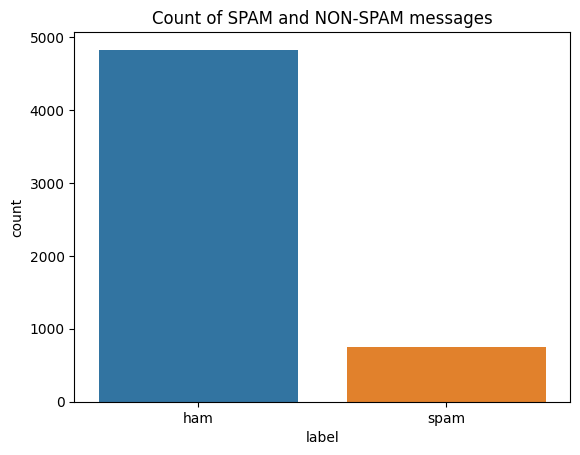

In [4]:
df.groupby('label').describe()
sns.countplot(data = df, x= df["label"]).set_title("Count of SPAM and NON-SPAM messages")
plt.show()

In [5]:
from collections import Counter

count1 = Counter(" ".join(df[df['label']=='ham']["msg"]).split()).most_common(10)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of ham", 1 : "count"})
count2 = Counter(" ".join(df[df['label']=='spam']["msg"]).split()).most_common(10)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of spam", 1 : "count_"})

In [6]:
print(data1)

  words of ham  count
0           to   1538
1          you   1462
2            I   1439
3          the   1029
4            a    977
5            i    742
6          and    739
7           in    736
8            u    651
9           is    645


In [7]:
print(data2)

  words of spam  count_
0            to     607
1             a     360
2          your     187
3          call     185
4            or     185
5           the     178
6             2     169
7           for     169
8           you     164
9            is     143


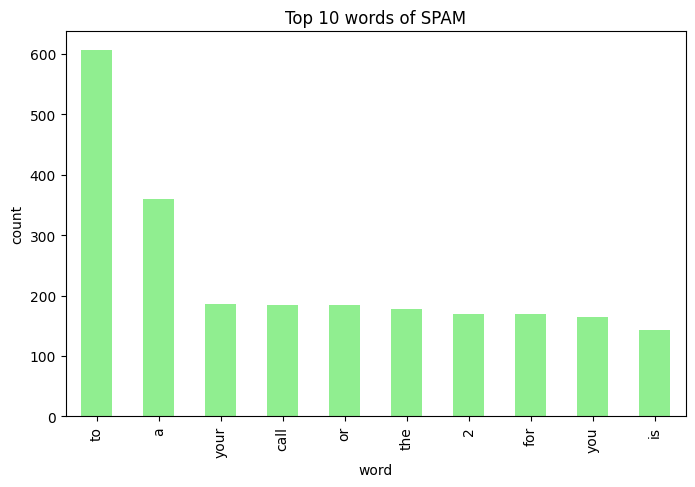

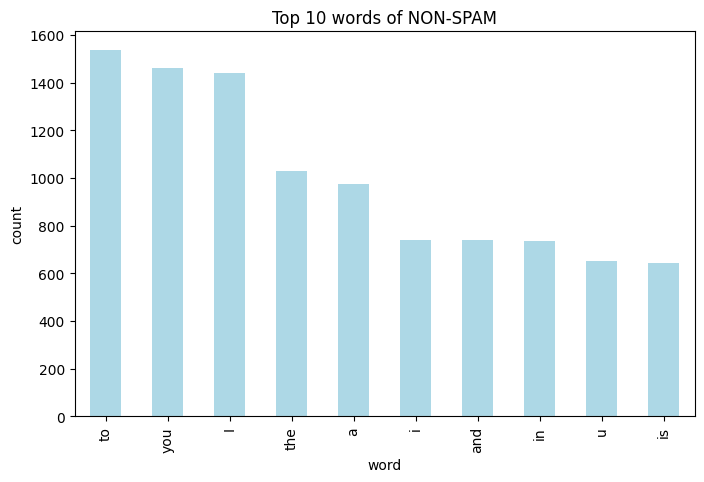

In [8]:
data2.plot.bar(legend = False, color = 'lightgreen', figsize = (8,5))
y_pos = np.arange(len(data2["words of spam"]))
plt.xticks(y_pos, data2["words of spam"])
plt.title('Top 10 words of SPAM')
plt.xlabel('word')
plt.ylabel('count')
plt.show()

data1.plot.bar(legend = False, color = 'lightblue',figsize = (8,5))
y_pos = np.arange(len(data1["words of ham"]))
plt.xticks(y_pos, data1["words of ham"])
plt.title('Top 10 words of NON-SPAM')
plt.xlabel('word')
plt.ylabel('count')
plt.show()

Data Preprocessing

In [9]:
import string
def data_preprocessing(mess):
    nopunc =[char for char in mess if char not in string.punctuation]
    nopunc=''.join(nopunc)
    arr = [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    s = ''
    for x in arr:
        s += x +' '
    return s

In [10]:
df['f_msg']=df['msg'].apply(data_preprocessing)
df.head()

,label,msg,f_msg
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [11]:
# missing values
df.isnull().sum()

label    0
msg      0
f_msg    0
dtype: int64

In [12]:
# check for duplicate values
df.duplicated().sum()

403

In [13]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [14]:
df.duplicated().sum()

0

In [15]:
df.shape

(5169, 3)

In [16]:
from collections import Counter

count1 = Counter(" ".join(df[df['label']=='ham']["f_msg"]).split()).most_common(10)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of ham", 1 : "count"})
count2 = Counter(" ".join(df[df['label']=='spam']["f_msg"]).split()).most_common(10)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of spam", 1 : "count_"})

Word Count After Preprocessing

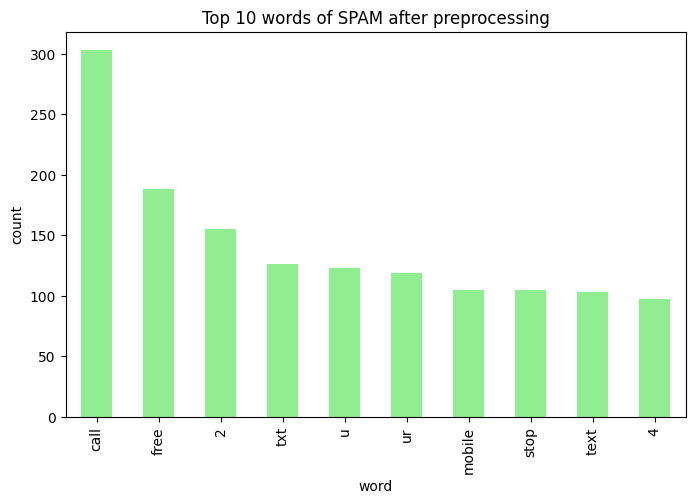

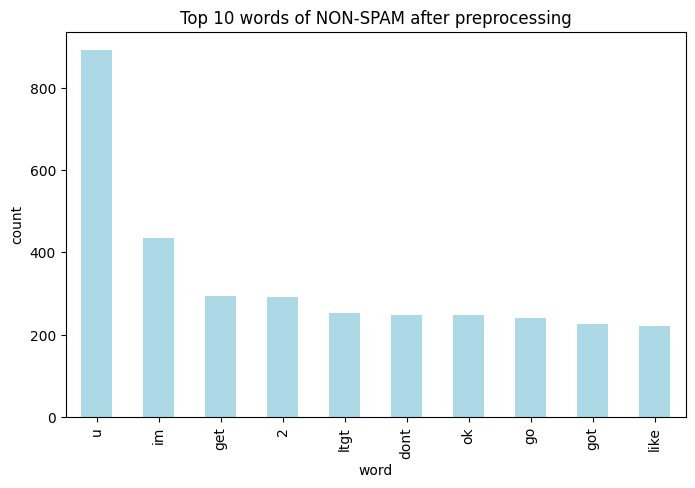

In [17]:
data2.plot.bar(legend = False, color = 'lightgreen', figsize = (8,5))
y_pos = np.arange(len(data2["words of spam"]))
plt.xticks(y_pos, data2["words of spam"])
plt.title('Top 10 words of SPAM after preprocessing')
plt.xlabel('word')
plt.ylabel('count')
plt.show()

data1.plot.bar(legend = False, color = 'lightblue',figsize = (8,5))
y_pos = np.arange(len(data1["words of ham"]))
plt.xticks(y_pos, data1["words of ham"])
plt.title('Top 10 words of NON-SPAM after preprocessing')
plt.xlabel('word')
plt.ylabel('count')
plt.show()

Test-Train Split

In [18]:
from sklearn.model_selection import train_test_split
total_vocablary_size = 800
msg_label = df['label'].map({'ham': 0, 'spam': 1}).values
X_train, X_test, y_train, y_test = train_test_split(df['f_msg'],msg_label,test_size=0.2)
print(len(X_train),len(X_test))

4135 1034


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words = total_vocablary_size)
tokenizer.fit_on_texts(X_train)
X_training = pad_sequences (tokenizer.texts_to_sequences(X_train))
X_testing = pad_sequences(tokenizer.texts_to_sequences(X_test))
epoch_count = 20

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          12800     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 13233 (51.69 KB)
Trainable params: 13233 (51.69 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

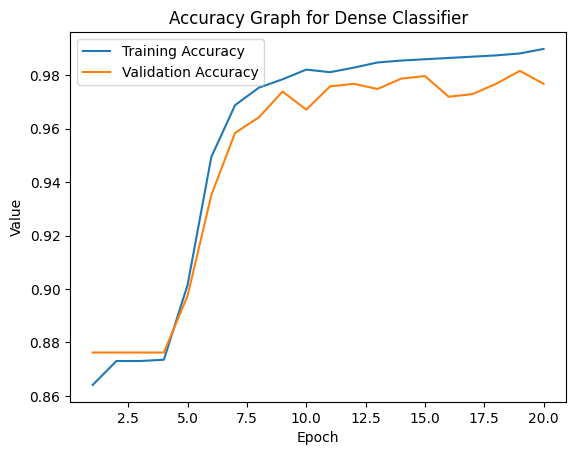

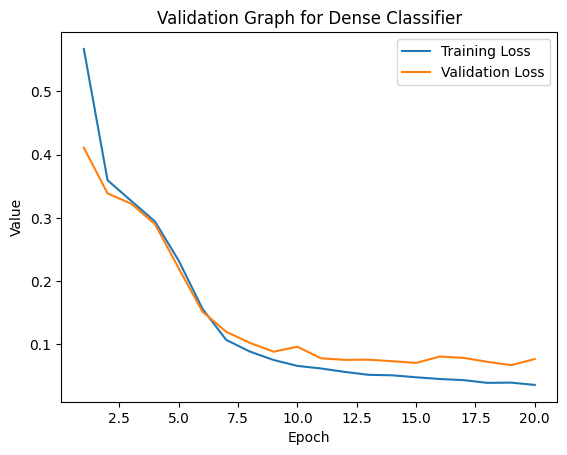

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
def dense_model():
    dense_model = Sequential()
    dense_model.add(Embedding(total_vocablary_size, 16))
    dense_model.add(GlobalAveragePooling1D())
    dense_model.add(Dense(24, activation='relu'))
    dense_model.add(Dropout(0.1))
    dense_model.add(Dense(1, activation='sigmoid'))

    dense_model.summary()

    dense_model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

    dense_hist = dense_model.fit(X_training, y_train, epochs=epoch_count, validation_data=(X_testing, y_test))

    x = dense_model.evaluate(X_testing, y_test)
    dense_los = x[0]
    dense_acc = x[1]
    print(x)
    print('Loss:- ',x[0])
    print('Accuracy:- ',x[1])

    plt.plot(range(1,(epoch_count+1)),dense_hist.history['accuracy'],label='Training Accuracy')
    plt.plot(range(1,(epoch_count+1)),dense_hist.history['val_accuracy'],label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Accuracy Graph for Dense Classifier')
    plt.legend()
    plt.show()

    plt.plot(range(1,(epoch_count+1)),dense_hist.history['loss'],label='Training Loss')
    plt.plot(range(1,(epoch_count+1)),dense_hist.history['val_loss'],label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Validation Graph for Dense Classifier')
    plt.legend()
    plt.show()

    return dense_model, dense_hist, dense_los, dense_acc

dense_model, dense_hist, dense_los, dense_acc = dense_model()

In [21]:
def preprocess_user_input(user_input):

    user_input = data_preprocessing(user_input)
    user_input_sequence = pad_sequences(tokenizer.texts_to_sequences([user_input]))
    return user_input_sequence
def predict_spam_or_not(user_input, model):

    preprocessed_input = preprocess_user_input(user_input)
    prediction = model.predict(preprocessed_input)
    label = "spam" if prediction[0][0] > 0.5 else "ham"

    return label
user_input = "Congratulations, you've won a free vacation! Claim your prize now!"
prediction = predict_spam_or_not(user_input, dense_model)
print("Predicted label:",prediction)

1/1 [==============================] - 0s 96ms/step
Predicted label: spam


In [22]:
def preprocess_user_input(user_input):
    user_input = data_preprocessing(user_input)
    user_input_sequence = pad_sequences(tokenizer.texts_to_sequences([user_input]))
    return user_input_sequence
def predict_spam_or_not(user_input, model):
    preprocessed_input = preprocess_user_input(user_input)
    prediction = model.predict(preprocessed_input)
    label = "spam" if prediction[0][0] > 0.5 else "ham"

    return label
user_input = "Enter the SMS text:FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv "
prediction = predict_spam_or_not(user_input, dense_model)
print("Predicted label:",prediction)

1/1 [==============================] - 0s 67ms/step
Predicted label: spam


In [24]:
def preprocess_user_input(user_input):

    user_input = data_preprocessing(user_input)
    user_input_sequence = pad_sequences(tokenizer.texts_to_sequences([user_input]))
    return user_input_sequence
def predict_spam_or_not(user_input, model):

    preprocessed_input = preprocess_user_input(user_input)
    prediction = model.predict(preprocessed_input)
    label = "spam" if prediction[0][0] > 0.5 else "ham"

    return label
user_input = "U dun say so early hor... U c already then say...!"
prediction = predict_spam_or_not(user_input, dense_model)
print("Predicted label:",prediction)

1/1 [==============================] - 0s 102ms/step
Predicted label: ham


In [23]:
def preprocess_user_input(user_input):

    user_input = data_preprocessing(user_input)
    user_input_sequence = pad_sequences(tokenizer.texts_to_sequences([user_input]))
    return user_input_sequence
def predict_spam_or_not(user_input, model):

    preprocessed_input = preprocess_user_input(user_input)
    prediction = model.predict(preprocessed_input)
    label = "spam" if prediction[0][0] > 0.5 else "ham"

    return label
user_input = "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
prediction = predict_spam_or_not(user_input, dense_model)
print("Predicted label:",prediction)

1/1 [==============================] - 0s 23ms/step
Predicted label: spam


In [25]:
def preprocess_user_input(user_input):

    user_input = data_preprocessing(user_input)
    user_input_sequence = pad_sequences(tokenizer.texts_to_sequences([user_input]))
    return user_input_sequence
def predict_spam_or_not(user_input, model):

    preprocessed_input = preprocess_user_input(user_input)
    prediction = model.predict(preprocessed_input)
    label = "spam" if prediction[0][0] > 0.5 else "ham"

    return label
user_input = "The Health & Glow Beauty Sale is Live! Buy 3K+ & get 3K+ FREE on h&g exclusive makeup, skin care, hair care & accessories. Tap: myhng.in/oct23 for more offers."
prediction = predict_spam_or_not(user_input, dense_model)
print("Predicted label:",prediction)

1/1 [==============================] - 0s 87ms/step
Predicted label: ham


In [26]:
def preprocess_user_input(user_input):

    user_input = data_preprocessing(user_input)
    user_input_sequence = pad_sequences(tokenizer.texts_to_sequences([user_input]))
    return user_input_sequence
def predict_spam_or_not(user_input, model):

    preprocessed_input = preprocess_user_input(user_input)
    prediction = model.predict(preprocessed_input)
    label = "spam" if prediction[0][0] > 0.5 else "ham"

    return label
user_input = "Alert: Beware of fraudsters sending SMS related to 5G upgrade / SIM block / suspension / Pending KYC or Document verification. DO NOT CALL BACK as they may ask you to download Apps to access your mobile phone and may get confidential information including OTP. DO NOT RESPOND to SMS from unknown numbers, asking for such information other than from our official SMS ID - ViCARE. DO NOT CLICK on unknown links received through social media or private messaging apps. Avoid falling victim to such frauds, block these numbers and report to https://cybercrime.gov.in"
prediction = predict_spam_or_not(user_input, dense_model)
print("Predicted label:",prediction)

1/1 [==============================] - 0s 44ms/step
Predicted label: spam
